# Import and Overall Functions

In [2]:
import atlas_mpl_style as ampl #style for matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt #interface for matplotlib
import numpy as np
import uproot #root files lesen
import os
import awkward as ak #similiar to numpy: working with arrays
from scipy.optimize import curve_fit
from scipy.stats import norm
import correctionlib.schemav2 as cs
import correctionlib

# ampl.use_atlas_style()
inputFile='/project/etp1/alory/zmass_muon_ntuple/run/mc20_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.deriv.DAOD_PHYS.e3601_s3681_z05.root'
events = uproot.open(inputFile+":myTree")


#events selection #include all branches manually
events = events.arrays([
    "muon_pt",
    "muon_eta",
    "muon_phi",
    "muon_charge",
    "finalWeight",
    "trigPassed_HLT_2mu14",
    "muon_pt_MUON_CB__1down",
    "muon_pt_MUON_CB__1up",
    ])

def histogram_ratio(events, bins, first_data, second_data):
    hist_one=histogram(events, bins, first_data)
    hist_two=histogram(events, bins, second_data)
        
    #arrays with no elements dont get plotted
    if np.any(hist_one) or np.any(hist_two):           
        #eliminate 1/0 cases
        hist_one[hist_one==0]=hist_two[hist_one==0]
        logical=np.logical_or(hist_two==0, hist_one==0)
        hist_one[logical]=1
        hist_two[logical]=1
        return hist_two/hist_one 
    
#makes hist data from events with or without selection applied
def histogram(events, bins, first_data, Error=False, GeV=True,):
    hist_sum=0
    weights=events.finalWeight
    data=events[first_data]

    if Error==True:
        weights=weights**2
    
    length=np.amax(ak.num(data))
    for i in range(length):
        #remove empty arrays
        bools=ak.any(data,axis=1)
        data=data[bools]
        weights=weights[bools]

        if GeV==True:
            hist, bins= np.histogram(data[:,0]/1000, bins= bins, weights=weights)
            hist_sum+=hist
        else:
            hist, bins= np.histogram(data[:,0], bins= bins, weights=weights)
            hist_sum+=hist

        #remove dimension
        data=data[:,1:]

    return hist_sum

def cleaned_ratio2(one,two):
    hist_one=np.copy(one)
    hist_two=np.copy(two)
    #arrays with no elements dont get plotted
    if np.any(hist_one) or np.any(hist_two):           
        #eliminate 1/0 cases
        hist_one[hist_one==0]=hist_two[hist_one==0]
        logical=np.logical_or(hist_two==0, hist_one==0)
        hist_one[logical]=1
        hist_two[logical]=1

        ratio=hist_two/hist_one
        return ratio
    
    else:
        hist_one[:]=1
        hist_two[:]=1
        ratio=hist_two/hist_one
        return ratio

# Background

## Invariant Mass Distribution

In [3]:
#apply selection: as args input the branches which should be selected
def selection(events,*args):
    # print("number of events before selection: {}".format(len(events)))
    # parts=[element for element in events.fields if "muon_pt" in element]
    for branch in args: 
        events = events[ak.num(events[branch]) == 2]
        events=events[np.all(events[branch]>14000,axis=1)]
        # print(len(events))
    events = events[events.trigPassed_HLT_2mu14] #numpy logik behaelt nur die trues
    # print("number of events after selection: {}".format(len(events))+"\n")

    #remove muons with charge !=1
    # print("before removing abs(1):",len(events.muon_pt))
    charge=np.all((np.abs(events.muon_charge)==1),axis=1)
    events=events[charge]
    # print("after removing abs(1):",len(events.muon_pt), "\n")

    #remove all pairs which are not myon and anti-muon
    charge=(np.sum(events.muon_charge, axis=1)==0)
    # print("before charge =+1 and -1:",len(events.muon_pt))
    events=events[charge]
    # print("after removing charge =+ and -1:",len(events.muon_pt))

    return events

def getInvariantMassSyst(events, syst=""): # invariant mass for systematics
    m = np.sqrt(2*events["muon_pt"+syst][:,0]*events["muon_pt"+syst][:,1]*
        (np.cosh(events["muon_eta"+syst][:,0]-events["muon_eta"+syst][:,1]) - np.cos(events["muon_phi"+syst][:,0]-events["muon_phi"+syst][:,1])))/1000.
    return(m)

def getInvariantMass(events,partofevents):  
    m = np.sqrt(2*events[partofevents][:,0]*events[partofevents][:,1]*
        (np.cosh(events["muon_eta"][:,0]-events["muon_eta"][:,1]) - np.cos(events["muon_phi"][:,0]-events["muon_phi"][:,1])))/1000.
    return(m)


events2 = uproot.open(inputFile+":myTree") #we need new data, so we have to reset the events array
systematics = ['MUON_SAGITTA_DATASTAT', 'MUON_CB', 'MUON_SCALE', 'MUON_SAGITTA_RESBIAS']
muon_branches = ["muon_pt","muon_eta","muon_phi","muon_charge"]
other_branches = ["finalWeight","trigPassed_HLT_2mu14"]
syst_branches = [s for s in events2.keys() if any([m in s for m in muon_branches])]

list= syst_branches + other_branches
events2 = events2.arrays(list)

bins=np.linspace(70,110,50)
bin_center=(bins[1:]+bins[:-1])/2

############### getting the errors for the individual selection
h_diffs_ind= []
for s in systematics: #systematics = ['MUON_SAGITTA_DATASTAT', 'MUON_CB', 'MUON_SCALE', 'MUON_SAGITTA_RESBIAS']
    up_syst = "_" + s + "__1up"
    down_syst = "_" + s + "__1down"

    m_up_ind = getInvariantMassSyst(selection(events2,"muon_pt"+ up_syst),syst=up_syst)
    m_down_ind= getInvariantMassSyst(selection(events2, "muon_pt"+down_syst),syst=down_syst) #calculation of the invariant masses for all the systematics

    # print(len(m_up),len(selection(events2, "muon_pt"+up_syst).finalWeight))

    h_up_ind,bins = np.histogram(m_up_ind,bins=bins,weights=selection(events2, "muon_pt"+up_syst).finalWeight) #making hist data
    h_down_ind,bins = np.histogram(m_down_ind,bins=bins,weights=selection(events2, "muon_pt"+down_syst).finalWeight)
    h_diffs_ind.append(np.absolute(h_up_ind- h_down_ind)/2.)

h_total_syst_ind = np.sqrt(np.sum(np.square(h_diffs_ind),axis=0))

events3=events2
events3 = events3[events.trigPassed_HLT_2mu14]
for branch in syst_branches: #looks at all muon_pt values and checks if they have enough detections an impulses
    if "muon_pt" in branch:
        events3 = events3[ak.num(events3[branch] > 14000) == 2]

################# getting the errors for all selection for every branch

h_diffs_all = []
for s in systematics: #systematics = ['MUON_SAGITTA_DATASTAT', 'MUON_CB', 'MUON_SCALE', 'MUON_SAGITTA_RESBIAS']
    up_syst_all = "_" + s + "__1up"
    down_syst_all = "_" + s + "__1down"
    m_up_all = getInvariantMassSyst(events3,syst=up_syst_all)
    m_down_all = getInvariantMassSyst(events3, syst=down_syst_all) #calculation of the invariant masses for all the systematicals
    
    h_up_all,bins = np.histogram(m_up_all,bins=bins,weights=events3.finalWeight) #making hist data
    h_down_all,bins = np.histogram(m_down_all,bins=bins,weights=events3.finalWeight)
    h_diffs_all.append(np.absolute(h_up_all - h_down_all)/2.) #appending the data to array                           
                              #looks at all muon_pt values and checks if they have enough detections an impulses
h_total_syst_all = np.sqrt(np.sum(np.square(h_diffs_all),axis=0))

################ m nominell

m = getInvariantMass(selection(events2, "muon_pt"), "muon_pt")
hist,bins = np.histogram(m,bins=bins,weights=selection(events2, "muon_pt").finalWeight)
errors_squared,bins = np.histogram(m,bins=bins,weights=selection(events2, "muon_pt").finalWeight*selection(events2, "muon_pt").finalWeight)
stat_errors = np.sqrt(errors_squared)


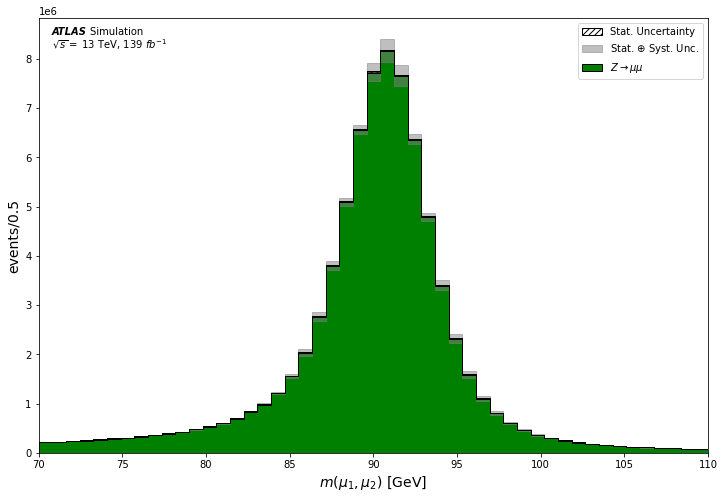

In [4]:

#plot
def plotHist(bins,hist,stat_errors,outName,function=None,syst_errs=None):
    label = r'$Z\rightarrow\mu\mu$'
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    bg = ampl.plot.Background(label,hist,stat_errs=stat_errors,syst_errs=syst_errs,color="green")
    plt.xlim([70,110])
    # plt.ylim((0,3e6))
    plt.xlabel(r"$m(\mu_{1},\mu_{2})$ [GeV]", fontsize=14)
    plt.ylabel("events/0.5", fontsize=14) #0.5
    ampl.plot.plot_backgrounds([bg], bins,ax=ax)
    ampl.plot.draw_atlas_label(0.02, 0.98, status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
    if function: 
        color = 'red'
        #ampl.plot.plot_signal(function["name"], bins, function["y"], color=red)plotHist(bins,hist,stat_errors, "zmass.pdf", syst_errs=h_total_syst_all)
    #clear plot
    plt.legend()

plotHist(bins,hist,stat_errors, "zmass_allSelection.pdf", syst_errs=h_total_syst_all)

# Analysis First Idea

## Normal PT Distribution

In [5]:
def plot_Ratio(events, bins, first_data, *args, logy=False, outName=None):
    bin_center=bins[:len(bins)-1]
    fig, (ax1,ax2)= plt.subplots(2,1,gridspec_kw={'height_ratios': [2, 1]},sharex=True, figsize=(12,8))

    hist_first=histogram(events, bins, first_data)
    
    # ax1.set_title("Total Distribution")


    if logy==True:
        ax1.set_yscale("log")

    labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
    colors=["tab:orange","tab:green"]
    for count, element in enumerate(args):
        hist=histogram(events, bins, element)
        ax1.step(bin_center,hist, label= labels[count], color=colors[count])

        ratio=histogram_ratio(events, bins,first_data , element)
        # ax2.step(bin_center,ratio,label='('+labels[count]+')'+"/"+'('+"Calibration"+')')
        ax2.step(bin_center,ratio,label=labels[count],color=colors[count])


    ax2.axhline(y = 1, color = 'black', linewidth=1,linestyle = '-')
    ax2.set_xlabel("Transverse Momentum [GeV]")
    # ax2.set_title("Ratios")
    ampl.plot.draw_atlas_label(0.02, 0.98,status="",ax=ax1, simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
    ax1.step(bin_center,hist_first, label= "Nominal",color="tab:blue")
    ax1.set_ylabel("Number of Events")
    ax2.set_ylim([0.99,1.01])
    ax2.set_ylabel("Systematic / Nominal")
    ax2.legend()   
    ax1.legend()

bins=np.linspace(2,100,50)
plot_Ratio(events,\
    bins,'muon_pt', "muon_pt_MUON_CB__1up","muon_pt_MUON_CB__1down")

## Phi Distribution

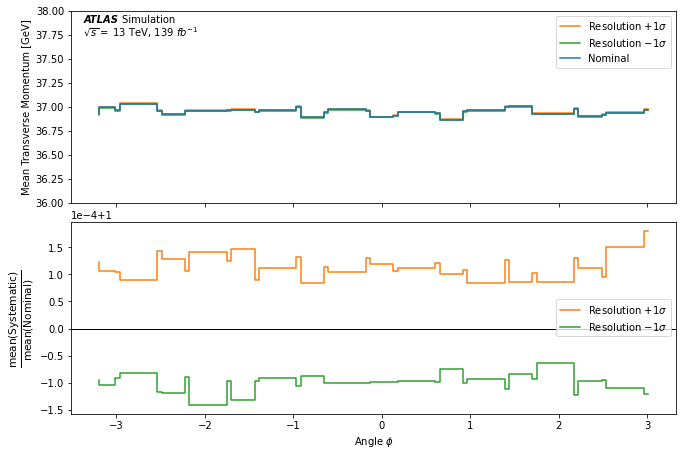

In [6]:
def PlotPhi(events, bins, phi,first_data,*args, outName=None):
    bin_center=bins[:len(bins)-1]
    fig, (ax2,ax3)= plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 1]},sharex=True, figsize=(12,8))

    momentum_flat, counts = ak.flatten(events[first_data]), ak.num(events[first_data])
    angle_flat=ak.flatten(events[phi])
    weights=np.repeat(events.finalWeight,counts)

    labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
    colors=["tab:orange","tab:green"]
    for count,data in enumerate(args):
        mom_array=np.array([])
        syst_array=np.array([])
        data_two_flat=ak.flatten(events[data])
        
        for index in range(len(bins)-1):
            weights=np.repeat(events.finalWeight,counts)

            phi_bool_flat=np.logical_and(angle_flat > bins[index],angle_flat <=bins[index+1])
            bin_data_momentum=momentum_flat[phi_bool_flat]
            bin_data_systematic=data_two_flat[phi_bool_flat]
            bin_weights=weights[phi_bool_flat]

            mean_mom=np.average(bin_data_momentum, weights=bin_weights)
            mean_syst=np.average(bin_data_systematic, weights=bin_weights)
            mom_array=np.append(mom_array, mean_mom)
            syst_array=np.append(syst_array, mean_syst)
            

        weighted_ratio=cleaned_ratio2(mom_array,syst_array)

        ax3.step(bin_center, weighted_ratio, label=labels[count], color=colors[count])
        ax2.step(bin_center, syst_array/1000, label=labels[count] ,color=colors[count])

    # ax2.step(bin_center, ratio_one/1000, label=' mean( '+"Calibration"+' )')
    ax2.step(bin_center, mom_array/1000, label="Nominal",color="tab:blue")
    ax2.set_ylim(36,38)
    ampl.plot.draw_atlas_label(0.02, 0.98,status="",ax=ax2, simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
    ax2.set_ylabel("Mean Transverse Momentum [GeV]")
    ax2.legend()
    
    ax3.set_ylabel(r"$\frac{\mathrm{mean(Systematic)}}{\mathrm{mean(Nominal)}}$", fontsize=15)
    ax3.axhline(y = 1, color = 'black', linewidth=1,linestyle = '-')
    ax3.set_xlabel(r"Angle $\phi$")
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax3.legend()   
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0.10)
    
    if outName!=None:
        plt.savefig(outName)
    plt.show()

bins=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
PlotPhi(events, bins, "muon_phi","muon_pt","muon_pt_MUON_CB__1up","muon_pt_MUON_CB__1down")

## Eta Distribution

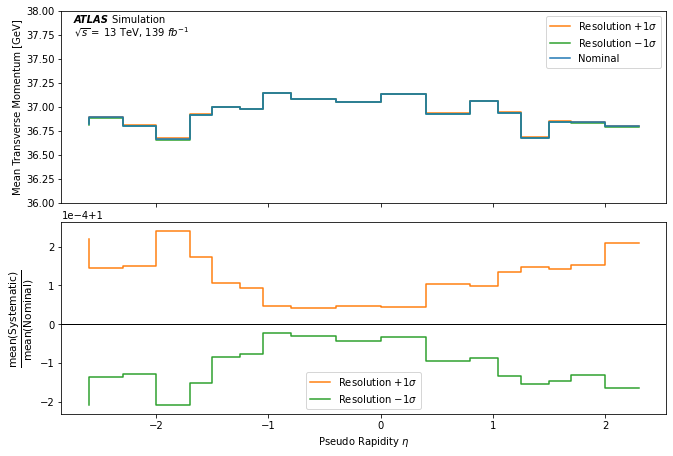

In [7]:
def PlotPhi(events, bins, phi,first_data,*args, outName=None):
    bin_center=bins[:len(bins)-1]
    fig, (ax2,ax3)= plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 1]},sharex=True, figsize=(12,8))

    momentum_flat, counts = ak.flatten(events[first_data]), ak.num(events[first_data])
    angle_flat=ak.flatten(events[phi])
    weights=np.repeat(events.finalWeight,counts)

    labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
    colors=["tab:orange","tab:green"]
    for count,data in enumerate(args):
        mom_array=np.array([])
        syst_array=np.array([])
        data_two_flat=ak.flatten(events[data])
        
        for index in range(len(bins)-1):
            weights=np.repeat(events.finalWeight,counts)

            phi_bool_flat=np.logical_and(angle_flat > bins[index],angle_flat <=bins[index+1])
            bin_data_momentum=momentum_flat[phi_bool_flat]
            bin_data_systematic=data_two_flat[phi_bool_flat]
            bin_weights=weights[phi_bool_flat]

            mean_mom=np.average(bin_data_momentum, weights=bin_weights)
            mean_syst=np.average(bin_data_systematic, weights=bin_weights)
            mom_array=np.append(mom_array, mean_mom)
            syst_array=np.append(syst_array, mean_syst)
            

        weighted_ratio=cleaned_ratio2(mom_array,syst_array)

        ax3.step(bin_center, weighted_ratio, label=labels[count],color=colors[count])
        ax2.step(bin_center, syst_array/1000, label=labels[count] ,color=colors[count])

    # ax2.step(bin_center, ratio_one/1000, label=' mean( '+"Calibration"+' )')
    ax2.step(bin_center, mom_array/1000, label="Nominal",color="tab:blue")
    ax2.set_ylim(36,38)
    ampl.plot.draw_atlas_label(0.02, 0.98,status="",ax=ax2, simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
    ax2.set_ylabel("Mean Transverse Momentum [GeV]")
    ax2.legend()
    
    ax3.set_ylabel(r"$\frac{\mathrm{mean(Systematic)}}{\mathrm{mean(Nominal)}}$", fontsize=15)
    ax3.axhline(y = 1, color = 'black', linewidth=1,linestyle = '-')
    ax3.set_xlabel(r"Pseudo Rapidity $\eta$")
    ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax3.legend()   
    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0.10)
    
    if outName!=None:
        plt.savefig(outName)
    plt.show()


bins=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
PlotPhi(events, bins, "muon_eta","muon_pt","muon_pt_MUON_CB__1up","muon_pt_MUON_CB__1down")

## Weights

The original Data is stored in input directorys <br>

 [73 files] inputDir1 = "/project/etp2/alory/zmass_muon_ntuple_output/z06/user.alory.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.e3601_s3681_r13144_p5631.z06" <br>
[93 files] inputDir2="/project/etp2/alory/zmass_muon_ntuple_output/z06/user.alory.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.e3601_s3681_r13145_p5631.z06"<br>
[54 files] inputDir3="/project/etp2/alory/zmass_muon_ntuple_output/z06/user.alory.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.e3601_s3681_r13167_p5631.z06" <br>
So 220 files in total

under '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example' a
re the slurm files. It sends every root file to the slurm system and the outputs will be gathered as numpy arrays in folders. <br><br>
['/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathPT',
  '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathCB',
 '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathErrorPT'
  '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathErrorCB'] <br><br>
  
 In order to add everything up, we are going to loop over every array and gather the data


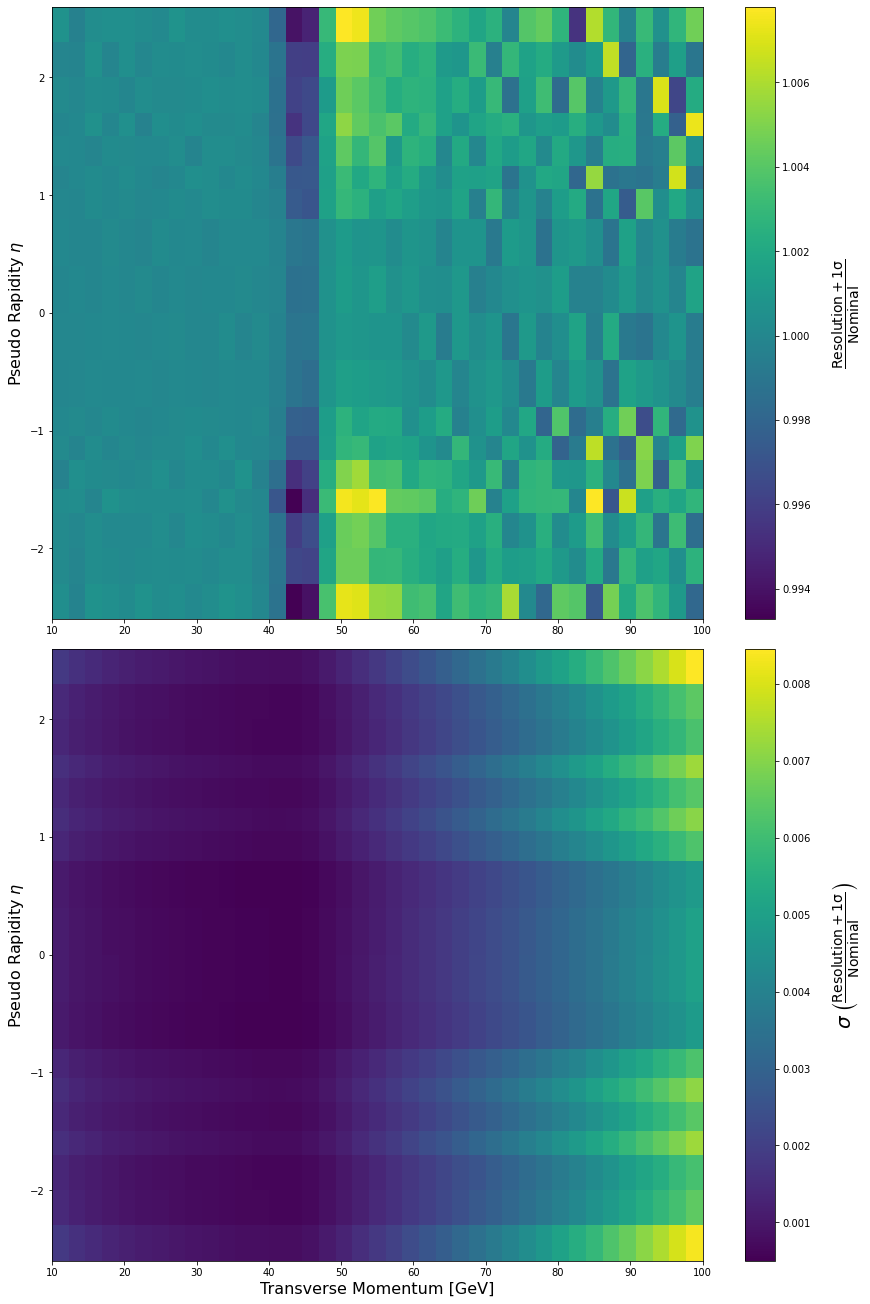

In [8]:
directorys=['/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathPT',
  '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathCB',
 '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathErrorPT',
  '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/weights/weightsPathErrorCB']
names=['weightsPathPT','weightsPathCB','weightsPathErrorPT','weightsPathErrorCB']


data={}
for i,element in enumerate(directorys):
    # if i==1: break
    add=0

    for inputFileName in os.listdir(element):
        totalpath=element+'/'+inputFileName
        x=np.load(totalpath)
        add=add+x
        
    data[names[i]]=add

pt_edges=np.linspace(10,100,40) #pt and eta edges have to be the same as the cell above
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])

Error_PT_Data=np.sqrt(data['weightsPathErrorPT'])
Error_CB_Up_Data=np.sqrt(data['weightsPathErrorCB'])
PT_Data=data['weightsPathPT']
CB_Data=data['weightsPathCB']

ratio=CB_Data/PT_Data
np.save('/home/m/Maximilian.Cammerer/Bachelor Thesis/numpy_arrays/weights_all',ratio)

gaussian=np.sqrt((Error_PT_Data/PT_Data)**2+(Error_CB_Up_Data/CB_Data)**2)*ratio

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,18), layout="constrained")
cmap1=ax1.pcolormesh(pt_edges,eta_edges,ratio.T, vmin=0.9, vmax=1.1)
cmap1=ax1.pcolormesh(pt_edges,eta_edges,ratio.T)
cmap2= ax2.pcolormesh(pt_edges,eta_edges,gaussian.T)

colorbar_weights=fig.colorbar(cmap1)
colorbar_error=fig.colorbar(cmap2)
colorbar_weights.set_label(r"$\frac{\mathrm{Resolution +1\sigma}}{\mathrm{Nominal}}$",fontsize=20,labelpad=20)
colorbar_error.set_label(r"$\sigma\:\left(\frac{\mathrm{Resolution +1\sigma}}{\mathrm{Nominal}}\right)$",fontsize=20,labelpad=20)


# ax1.set_xlabel('Transverse Momentum ', fontsize=14)
ax1.set_ylabel(r'Pseudo Rapidity $\eta$',fontsize=16)
# ax1.set_title('muon_pt_MUON_CB__1up / muon_pt',fontsize=16)

ax2.set_xlabel('Transverse Momentum [GeV]',fontsize=16)
ax2.set_ylabel(r'Pseudo Rapidity $\eta$',fontsize=16)
# ax2.set_title('Sigma with Gaussian Error',fontsize=16)
plt.show()

## Looking at the Accuracy

In [9]:
def histogram2D(events, x_edges, y_edges, x_data, y_data, GeV=True, Error=False): # x and y data have to be in the same shape so the bools array can work
    hist_sum=0
    weights=events.finalWeight
    x_data=events[x_data]
    y_data=events[y_data]
    
    if Error==True:
        weights=weights**2
    
    length=np.amax(ak.num(x_data))
    for i in range(length):
        # print(i)
        #remove empty arrays
        bools=ak.any(x_data,axis=1)
        x_data=x_data[bools]
        y_data=y_data[bools]
        weights=weights[bools]
       
        if GeV==True:
            hist, xedges, yedges= np.histogram2d(x_data[:,0]/1000., y_data[:,0], bins=(x_edges, y_edges), weights=weights) # only one will be divided bei 1000       
            hist_sum+=hist
            # print("v",hist)
        else:
            hist, xedges, yedges= np.histogram2d(x_data[:,0],y_data[:,0], bins=(x_edges, y_edges), weights=weights)
            hist_sum+=hist
            # print("z",hist)

        #remove first dimension
        x_data=x_data[:,1:]
        y_data=y_data[:,1:]
        # print(ak.to_list(x_data[0:5]))

    return hist_sum

## Possibility to create 1D output data with the addes weight
def histogram2D_addWeight(events, x_edges, y_edges, x_data, y_data, Correction, GeV=True, out_1D_Hist=False): # x and y data have to be in the same shape so the bools array can work
    hist_sum=0
    weights=events.finalWeight
    x_data=events[x_data]
    y_data=events[y_data]
    
    length=np.amax(ak.num(x_data))
    for i in range(length):
        # print(i)
        #remove empty arrays
        bools=ak.any(x_data,axis=1)
        x_data=x_data[bools]
        y_data=y_data[bools]
        weights=weights[bools]
        
        if GeV==True:
            corr=Correction.to_evaluator().evaluate(x_data[:,0]/1000, y_data[:,0])# only one will be divided bei 1000
            if out_1D_Hist==False:
                hist, xedges, yedges= np.histogram2d(x_data[:,0]/1000, y_data[:,0], bins=(x_edges, y_edges), weights=weights*corr)
            else:
                hist, bins = np.histogram(x_data[:,0]/1000, bins= x_edges, weights=weights*corr)
            hist_sum+=hist
        else:
            corr=Correction.to_evaluator().evaluate(x_data[:,0], y_data[:,0])# only one will be divided bei 1000
            if out_1D_Hist==False:
                hist, xedges, yedges= np.histogram2d(x_data[:,0], y_data[:,0], bins=(x_edges, y_edges), weights=weights*corr)
            else:
                hist, bins = np.histogram(x_data[:,0], bins= x_edges, weights=weights*corr)
            hist_sum+=hist
            
        #remove first dimension
        x_data=x_data[:,1:]
        y_data=y_data[:,1:]
        # print(ak.to_list(data[0:20]))

    return hist_sum

def Correction(edge1,edge2, weights):
    edge1=edge1.tolist()
    edge2=edge2.tolist()
    weights=weights.flatten()
    weights=weights.tolist()
    
    Correction = cs.Correction(
        name="CB_Weights",
        version=1,
        inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
                cs.Variable(name='eta',type='real', description='Muon Eta Value'),
        ],
        output=cs.Variable(name="weight", type="real", description="Correction Weight"),
        data=cs.MultiBinning(
            nodetype="multibinning",
            inputs=["pt","eta"],
            edges=[edge1,edge2],
            content=weights,
            flow="1",
        ),
    )
    return Correction


In [10]:
bins=np.linspace(10,100,40)
bin_center=bins[:len(bins)-1]

pt_edges=np.linspace(10,100,40)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])

### creating the corrected data
PT_Data=histogram2D(events, pt_edges,eta_edges, 'muon_pt','muon_eta')
CB_Up_Data=histogram2D(events, pt_edges,eta_edges, 'muon_pt_MUON_CB__1up','muon_eta')
# ratio_matrix=cleaned_ratio2(PT_Data,CB_Up_Data)
ratio_matrix=np.load('/home/m/Maximilian.Cammerer/Bachelor Thesis/numpy_arrays/weights_all.npy')

### make the correction       
CB_Correction=Correction(pt_edges,eta_edges,ratio_matrix)
Corr_Up_Data=histogram2D_addWeight(events, pt_edges,eta_edges,'muon_pt','muon_eta', CB_Correction)
        
hist_CB=histogram(events, bins, 'muon_pt_MUON_CB__1up')
hist_PT=histogram(events, bins, 'muon_pt')
hist_CB_CLib=histogram2D_addWeight(events, pt_edges,eta_edges,'muon_pt','muon_eta', CB_Correction, out_1D_Hist=True)

#creating the graph
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,8), sharex=True)
plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0.05)


labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
colors=["tab:orange","tab:green"]
ax1.step(bin_center, hist_CB, label=labels[0],color=colors[0])
ax1.step(bin_center, hist_PT, label='Nominal',color="tab:blue")
ax1.step(bin_center, hist_CB_CLib, label='Correction',color="black")

ampl.plot.draw_atlas_label(0.02, 0.98,status="",ax=ax1, simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
ax1.set_ylabel('Number of Events')
# ax1.set_title('Looking at the accuracy of Correctionlib calculated CB')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend()

ratio_PT_CB=cleaned_ratio2(hist_PT,hist_CB)
ratio_PT_Corr=Correctionlib=cleaned_ratio2(hist_PT,hist_CB_CLib)
ratio_CB_Corr=cleaned_ratio2(hist_CB, hist_CB_CLib)


ax2.step(bin_center, ratio_PT_CB, label='{}'.format(labels[0]),color=colors[0])
ax2.step(bin_center, ratio_PT_Corr, label="Correction" ,color='black')
# ax2.step(bin_center, ratio_CB_Corr, label='(Correction)/({})'.format(labels[0]), color='black')
ax2.set_ylim(0.995,1.005)
ax2.set_ylabel("Systematic / Nominal")
ax2.axhline(y = 1, color = 'black', linewidth=1,linestyle = '-')
ax2.legend()

ax2.set_xlabel('Transverse Momentum [GeV]')
plt.show()

## Time Stuff

save the correction to import it later

In [10]:
import time
slurm_weights=np.load('/home/m/Maximilian.Cammerer/Bachelor Thesis/numpy_arrays/weights_all.npy')

def Correction(edge1,edge2, weights,name_as_string):
    edge1=edge1.tolist()
    edge2=edge2.tolist()
    weights=weights.flatten()
    weights=weights.tolist()
    
    Correction = cs.Correction(
        name=name_as_string,
        version=1,
        inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
                cs.Variable(name='eta',type='real', description='Muon Eta Value'),
        ],
        output=cs.Variable(name="weight", type="real", description="Correction Weight"),
        data=cs.MultiBinning(
            nodetype="multibinning",
            inputs=["pt","eta"],
            edges=[edge1,edge2],
            content=weights,
            flow="1",
        ),
    )
    return Correction

#create the correction
pt_edges=np.linspace(10,100,40)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])

CB_Correction=Correction(pt_edges,eta_edges,slurm_weights,'CB_Correction') #create correction

#save the correction by creating a correction set
cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description="my custom corrections",
    corrections=[
        CB_Correction # include all the wanted correctios
    ],
)

with open('/home/m/Maximilian.Cammerer/Bachelor Thesis/corrections/slurm_correction.json', "w") as fout:
    fout.write(cset.json(exclude_unset=True))

import gzip

with gzip.open("mycorrections.json.gz", "wt") as fout:
    fout.write(cset.json(exclude_unset=True))


In [11]:
start = time.time()
#import alle the needed stuff
inputFile='/project/etp1/alory/zmass_muon_ntuple/run/mc20_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.deriv.DAOD_PHYS.e3601_s3681_z05.root' # larger file
events_5 = uproot.open(inputFile+":myTree")

events_5 = events_5.arrays([
    "muon_pt",
    "muon_eta",
    "muon_phi",
    "muon_charge",
    "finalWeight",
    "trigPassed_HLT_2mu14",
    ])

bins=np.linspace(10,100,40)
selected_events=selection(events_5,"muon_pt")
Correction = correctionlib.CorrectionSet.from_file('/home/m/Maximilian.Cammerer/Bachelor Thesis/corrections/slurm_correction.json')
Correction=Correction['CB_Correction']

events_5=selected_events

ptflat, counts = ak.flatten(events_5.muon_pt), ak.num(events_5.muon_pt)
etaflat, counts = ak.flatten(events_5.muon_eta), ak.num(events_5.muon_eta)

weight = ak.unflatten(Correction.evaluate(ptflat,etaflat),counts)
weight_unflattend=Correction.evaluate(ptflat,etaflat)

mass_CB= getInvariantMass(selected_events, 'muon_pt')
hist, bins=np.histogram(mass_CB, bins=bins,weights=selected_events.finalWeight*weight[:,0])

end = time.time()
print(end - start)

7.1215245723724365


In [12]:
start = time.time()
#import alle the needed stuff
inputFile='/project/etp1/alory/zmass_muon_ntuple/run/mc20_13TeV.361107.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zmumu.deriv.DAOD_PHYS.e3601_s3681_z05.root'
events_CB = uproot.open(inputFile+":myTree")


#events selection #include all branches manually
events_CB = events_CB.arrays([
    "muon_pt",
    "muon_eta",
    "muon_phi",
    "muon_charge",
    "finalWeight",
    "trigPassed_HLT_2mu14",
    "muon_pt_MUON_CB__1up",
    ])

#calculate the masses and get the hist data
bins=np.linspace(10,100,40)
selected_events_CB=selection(events_CB,"muon_pt_MUON_CB__1up",)
mass_CB= getInvariantMass(selected_events_CB, "muon_pt_MUON_CB__1up")
hist, bins=np.histogram(mass_CB, bins=bins,weights=selected_events_CB.finalWeight)  

end = time.time()
print(end - start)

7.971301794052124


# Analysis Second Idea

## Difference Plot

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot: xlabel='Transverse Momentum: $\\mathbf{(Nominal - Systematic)}$ [GeV]', ylabel='Number of Events'>)

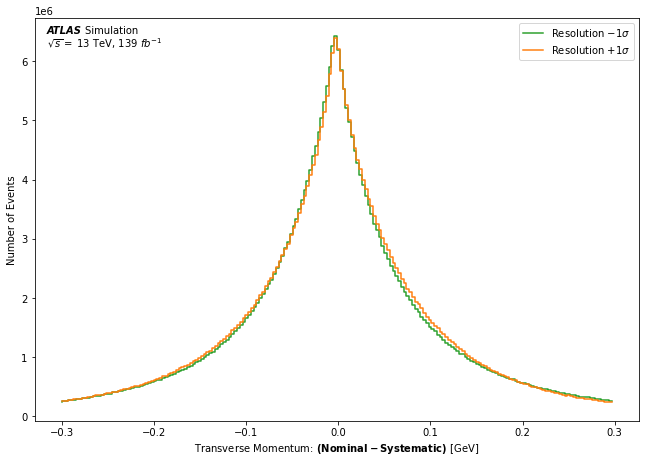

In [13]:

def histogram_diff(events, bins, first_data, second_data):
    hist_sum=0
    events2=events
    weights=events2.finalWeight
    data1=events2[first_data] 
    data2=events2[second_data]
    
    length=np.amax(ak.num(data1))
    for i in range(length):
        #remove empty arrays
        bools=ak.any(data1,axis=1) 
        #first data and second data should have the same shape thats why it doesnt matter which is taken for selection
        data1=data1[bools]
        data2=data2[bools]
        weights=weights[bools]

        hist, bins= np.histogram((data1[:,0]-data2[:,0])/1000., bins= bins, weights=weights)
        hist_sum+=hist

        #remove dimension
        data1=data1[:,1:]
        data2=data2[:,1:]
        # print(ak.to_list(data[0:20]))
    
    return hist_sum

def plotDiff(events,bins,first_data, second_data_up=None, second_data_down=None, outName=None): #Selection=None
    events2=events
    bin_center=bins[:len(bins)-1]
    fig, ax= plt.subplots(1,1,figsize=(12,8))



    labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
    colors=["tab:orange","tab:green"]
    if second_data_up!=None:
        hist_up= histogram_diff(events2, bins, first_data, second_data_up)
        label1 = "{}".format(labels[1])
        ax.step(bin_center, hist_up, label=label1, color=colors[1]) 

        # if ak.any(Selection[second_data_up])!=False: #makes second graph if there is any data in Selection
        #     hist_up= histogram_diff(bins, first_data, second_data_up, Selection)
        #     label1 = "("+first_data+")"+"  -  "+ "("+second_data_up+")"+"[S]"
        #     ax.step(bin_center, hist_up, label=label1, color='blue')

    if second_data_down!=None: 
        hist_down= histogram_diff(events2, bins, first_data, second_data_down)
        label2 = "{}".format(labels[0])
        ax.step(bin_center, hist_down, label=label2, color=colors[0]) 

        # if ak.any(Selection[second_data_down])!=False: #makes second graph if there is any data in Selection
        #     hist_up= histogram_diff(bins, first_data, second_data_down, Selection)
        #     label2 = "("+first_data+")"+"  -  "+ "("+second_data_down+")"+"[S]"
        #     ax.step(bin_center, hist_up, label=label2, color='red')

    # if second_data_up==None and second_data_down==None:
    #     ax.step(bin_center, histogram(events, bins,first_data))

    ax.set_xlabel(r"Transverse Momentum: $\mathbf{(Nominal - Systematic)}$ [GeV]")
    ax.set_ylabel("Number of Events")
    ax.legend(loc='upper right')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ampl.plot.draw_atlas_label(0.02, 0.98,status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")

    plt.subplots_adjust(left=0.15, bottom=0.15, right=0.85, top=0.85, hspace=0)

    if outName!=None:
        plt.savefig(outName)

    return fig, ax

bins=np.linspace(-0.3,0.3,200)
plotDiff(events,bins,"muon_pt","muon_pt_MUON_CB__1down","muon_pt_MUON_CB__1up")

## Eta Dependence

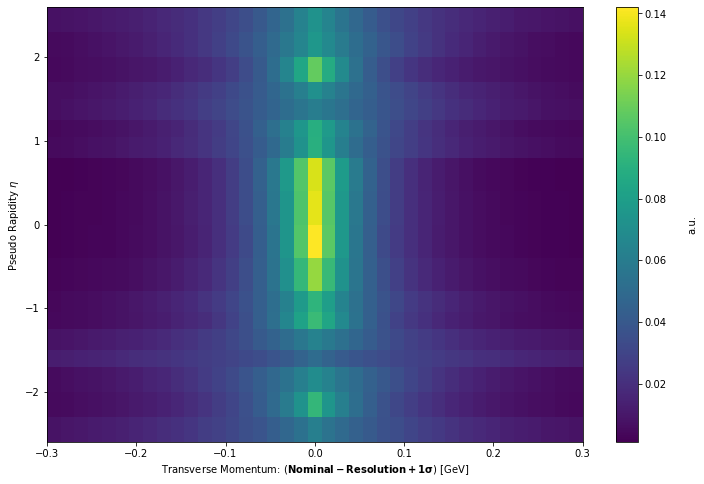

In [14]:
def plot_2D_Diff(events,bins_diff, bins_compare,first_data, second_data, compare_data,GeV=True, Density=True, Log=False): #Selection=None
    # bin_center=(bins[:-1]+bins[1:])/2
    fig, ax= plt.subplots(1,1,figsize=(12,8))

    ax.set_xlabel(r"Transverse Momentum: ($\mathbf{Nominal - }\mathbf{Resolution +1\sigma}$) [GeV]")
    ax.set_ylabel(r"Pseudo Rapidity $\eta$")
    
    hist_sum=0
    weights=events.finalWeight
    diff_data=events[first_data]-events[second_data]
    compare_data=events[compare_data]
    
    
    length=np.amax(ak.num(diff_data))
    for i in range(length):
        # print(i)
        #remove empty arrays
        bools=ak.any(diff_data,axis=1)
        diff_data=diff_data[bools]
        compare_data=compare_data[bools]
        weights=weights[bools]

        if GeV==True:
            hist, xedges, yedges= np.histogram2d(compare_data[:,0], diff_data[:,0]/1000., bins=(bins_compare, bins_diff), weights=weights) # only one will be divided bei 1000       
            hist_sum+=hist
            # print("v",hist)

        #remove first dimension
        diff_data=diff_data[:,1:]
        compare_data=compare_data[:,1:]

    if Density==True:
        row_sums = hist_sum.sum(axis=1)
        hist_sum = hist_sum / row_sums[:, np.newaxis]
        
    if Log==True:
        hist_sum=np.log10(hist_sum)

    #Plot Data
    cmap1=ax.pcolormesh(bins_diff, bins_compare,hist_sum)
    colorbar=fig.colorbar(cmap1)
    colorbar.set_label("a.u.", labelpad=20)
    
    
    plt.show()

bins_diff=np.linspace(-0.3,0.3,40)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])

plot_2D_Diff(events,bins_diff, eta_edges,'muon_pt','muon_pt_MUON_CB__1up','muon_eta',GeV=True)


## Phi Dependence

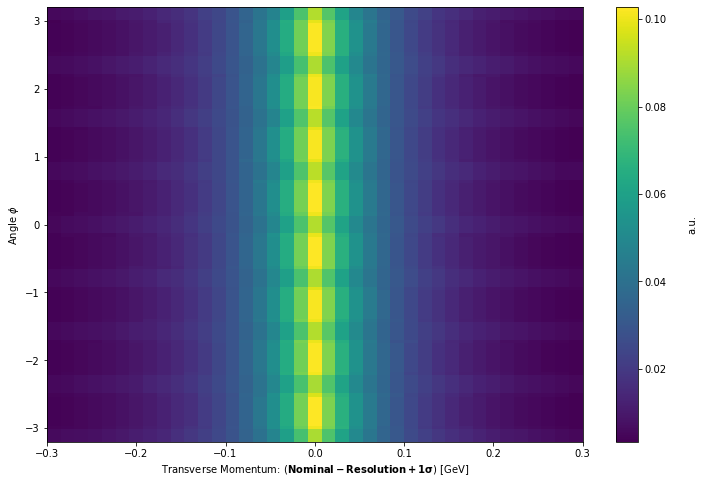

In [15]:
def plot_2D_Diff(events,bins_diff, bins_compare,first_data, second_data, compare_data,GeV=True, Density=True, Log=False): #Selection=None
    # bin_center=(bins[:-1]+bins[1:])/2
    fig, ax= plt.subplots(1,1,figsize=(12,8))

    ax.set_xlabel(r"Transverse Momentum: ($\mathbf{Nominal - }\mathbf{Resolution +1\sigma}$) [GeV]")
    ax.set_ylabel(r"Angle $\phi$")
    
    hist_sum=0
    weights=events.finalWeight
    diff_data=events[first_data]-events[second_data]
    compare_data=events[compare_data]
    
    
    length=np.amax(ak.num(diff_data))
    for i in range(length):
        # print(i)
        #remove empty arrays
        bools=ak.any(diff_data,axis=1)
        diff_data=diff_data[bools]
        compare_data=compare_data[bools]
        weights=weights[bools]

        if GeV==True:
            hist, xedges, yedges= np.histogram2d(compare_data[:,0], diff_data[:,0]/1000., bins=(bins_compare, bins_diff), weights=weights) # only one will be divided bei 1000       
            hist_sum+=hist
            # print("v",hist)

        #remove first dimension
        diff_data=diff_data[:,1:]
        compare_data=compare_data[:,1:]

    if Density==True:
        row_sums = hist_sum.sum(axis=1)
        hist_sum = hist_sum / row_sums[:, np.newaxis]
        
    if Log==True:
        hist_sum=np.log10(hist_sum)

    #Plot Data
    cmap1=ax.pcolormesh(bins_diff, bins_compare,hist_sum)
    colorbar=fig.colorbar(cmap1)
    colorbar.set_label("a.u.", labelpad=20)
    
    
    plt.show()

bins_diff=np.linspace(-0.3,0.3,40)
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
plot_2D_Diff(events,bins_diff, phi_edges,'muon_pt','muon_pt_MUON_CB__1up','muon_phi',GeV=True)

In [16]:
import matplotlib.colors as colors

def plot_2D_Diff(events,bins_diff, bins_compare,first_data, second_data, compare_data,GeV=True, Density=True, Log=False): #Selection=None
    # bin_center=(bins[:-1]+bins[1:])/2
    fig, ax= plt.subplots(1,1,figsize=(12,8))

    ax.set_xlabel(r"Transverse Momentum: ($\mathbf{Nominal - }\mathbf{Resolution +1\sigma}$) [GeV]")
    ax.set_ylabel(r"Transverse Momentum [GeV]")
    
    hist_sum=0
    weights=events.finalWeight
    diff_data=events[first_data]-events[second_data]
    compare_data=events[compare_data]
    
    # if Error==True:
    #     weights=weights**2
    
    length=np.amax(ak.num(diff_data))
    for i in range(length):
        # print(i)
        #remove empty arrays
        bools=ak.any(diff_data,axis=1)
        diff_data=diff_data[bools]
        compare_data=compare_data[bools]
        weights=weights[bools]

        if GeV==True:
            hist, xedges, yedges= np.histogram2d(compare_data[:,0]/1000, diff_data[:,0]/1000., bins=(bins_compare, bins_diff), weights=weights) # only one will be divided bei 1000       
            hist_sum+=hist
            # print("v",hist)

        #remove first dimension
        diff_data=diff_data[:,1:]
        compare_data=compare_data[:,1:]

    if Density==True:
        row_sums = hist_sum.sum(axis=1)
        hist_sum = hist_sum / row_sums[:, np.newaxis]
        
    if Log==True:
        hist_sum=np.log10(hist_sum)

    #Plot Data
    cmap1=ax.pcolormesh(bins_diff, bins_compare,hist_sum, norm=colors.LogNorm())
    colorbar=fig.colorbar(cmap1)
    colorbar.set_label("a.u.", labelpad=20)
    
    
    plt.show()

bins_diff=np.linspace(-0.3,0.3,40)
pt_edges=np.linspace(0,100,20)
plot_2D_Diff(events,bins_diff, pt_edges,'muon_pt','muon_pt_MUON_CB__1up','muon_pt',GeV=True, Density=True)

In [17]:
del colors

## Creating the Correction

In [18]:
overall_bins=np.linspace(-1.5,1.5,60)
diff_edges=np.linspace(-1.5,1.5,60)
#counting length of files to check if everything works 
_, _, files = next(os.walk(
     '/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/4D_hists_pt_100_down'))
file_count = len(files)
file_count

220

In [19]:
hist_sum_slurm=0
path_directory='/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/4D_hists_pt_100'
for inputFileName in os.listdir(path_directory):
    totalpath=os.path.join(path_directory, inputFileName)
    hists=np.load(totalpath)
    hist_sum_slurm+=hists

#hist_sum_slurm normieren
sum_array = np.sum(hist_sum_slurm, axis=-1, keepdims=True)
hist_sum_slurm=hist_sum_slurm/sum_array


#variable binning for pt
bins_one=np.linspace(0,38,20)
bins_steep=np.linspace(38,55,50)
bins_three=np.linspace(55,100,20)

overall_bins=np.linspace(-1.5,1.5,60)
diff_edges=np.linspace(-1.5,1.5,60)

pt_edges=np.concatenate((bins_one[:-1],bins_steep[:-1],bins_three))


# pt_edges=np.linspace(0,100,20) 
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
# diff_edges=np.linspace(-0.3,0.3,20)
diff_edges=overall_bins

# addition=np.linspace(0,0.005,20)
addition=np.linspace(0,0.005,len(overall_bins))


density4d=hist_sum_slurm.tolist()

for element_first in range(len(pt_edges)-1):
    # print(element_first)
    for element_second in range(len(eta_edges)-1):
        # print(element_second)
        for element_third in range(len(phi_edges)-1):
            # print(element_third)

# for element_first in range(6,7):
#     for element_second in range(6,7):
#         for element_third in range(6,7):

            density=density4d[element_first][element_second][element_third]

            density=np.where(np.array(density)<0.,0,density)

            #making new edges, which width represents the proability
            new_edges = np.cumsum(density)
            new_edges = [0] + new_edges.tolist() #adds 0 as first bin #so that the width of each bin represents probality 
            
            # if np.any(np.diff(new_edges) < 0)==True:
            #     print(element_first,element_second,element_third)

            # density4d[element_first][element_second][element_third]=new_edges
            density4d[element_first][element_second][element_third]=new_edges+addition

            if np.any(np.diff(density4d[element_first][element_second][element_third]) <= 0)==True:
                print(element_first,element_second,element_third)
            
            
            # density4d[element_first][element_second][element_third]=sorted_values
            
# density4d=list(density4d)           
#takes the middle of each bin of the diff_edges. changes length by -1
contents = [a+(max(diff_edges)-min(diff_edges))/(len(diff_edges)-1)/2. for a in diff_edges[:-1]]
bins_one=np.linspace(0,38,20)
bins_steep=np.linspace(38,55,50)
bins_three=np.linspace(55,100,20)

pt_edges=np.concatenate((bins_one[:-1],bins_steep[:-1],bins_three))


# pt_edges=np.linspace(0,100,20)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
# diff_edges=np.linspace(-0.3,0.3,20)
diff_edges=overall_bins


contents = [a+(max(diff_edges)-min(diff_edges))/(len(diff_edges)-1)/2. for a in diff_edges[:-1]]


ptsmear = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
            cs.Variable(name="eta", type="real", description="Muon eta"),
            cs.Variable(name="phi", type="real", description="Muon phi"),
            cs.Variable(name="rand", type="real", description="random value between 0 and 1")],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Binning(
        nodetype="binning",
        input="pt",
        edges=pt_edges.tolist(),
        flow="clamp",
        content=[cs.Binning(
                nodetype="binning",
                input="eta",
                edges=eta_edges.tolist(),
                flow="clamp",
                content=[cs.Binning(
                        nodetype="binning",
                        input="phi",
                        edges=phi_edges.tolist(),
                        flow="clamp",
                        content=[cs.Binning(
                                nodetype="binning",
                                input="rand",
                                edges=(density4d[count_first][count_second][count_third]).tolist(),
                                flow=0,
                                content=contents
                                )
                                for count_third, third_dimension_element in enumerate(second_dimension_element)]
                        )               
                        for count_second, second_dimension_element in enumerate(first_dimension_element)]
                )
                for count_first, first_dimension_element in enumerate(density4d)]
        )
 
)


/tmp/user/23417/ipykernel_791433/3311833633.py:10: RuntimeWarning: invalid value encountered in true_divide
  hist_sum_slurm=hist_sum_slurm/sum_array


In [20]:
hist_sum_slurm_down=0
path_directory='/home/m/Maximilian.Cammerer/Slurm/zmass_analysis/slurm_example/4D_hists_pt_100_down'
for inputFileName in os.listdir(path_directory):
    totalpath=os.path.join(path_directory, inputFileName)
    hists=np.load(totalpath)
    hist_sum_slurm_down+=hists

#hist_sum_slurm normieren
sum_array = np.sum(hist_sum_slurm_down, axis=-1, keepdims=True)
hist_sum_slurm_down=hist_sum_slurm_down/sum_array


#variable binning for pt
bins_one=np.linspace(0,38,20)
bins_steep=np.linspace(38,55,50)
bins_three=np.linspace(55,100,20)

overall_bins=np.linspace(-1.5,1.5,60)
diff_edges=np.linspace(-1.5,1.5,60)

pt_edges=np.concatenate((bins_one[:-1],bins_steep[:-1],bins_three))


# pt_edges=np.linspace(0,100,20) 
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
# diff_edges=np.linspace(-0.3,0.3,20)
diff_edges=overall_bins

# addition=np.linspace(0,0.005,20)
addition=np.linspace(0,0.005,len(overall_bins))


density4d_down=hist_sum_slurm_down.tolist()

for element_first in range(len(pt_edges)-1):
    # print(element_first)
    for element_second in range(len(eta_edges)-1):
        # print(element_second)
        for element_third in range(len(phi_edges)-1):
            # print(element_third)

# for element_first in range(6,7):
#     for element_second in range(6,7):
#         for element_third in range(6,7):

            density_down=density4d_down[element_first][element_second][element_third]

            density_down=np.where(np.array(density_down)<0.,0,density_down)

            #making new edges, which width represents the proability
            new_edges = np.cumsum(density_down)
            new_edges = [0] + new_edges.tolist() #adds 0 as first bin #so that the width of each bin represents probality 
            
            # if np.any(np.diff(new_edges) < 0)==True:
            #     print(element_first,element_second,element_third)

            # density4d[element_first][element_second][element_third]=new_edges
            density4d_down[element_first][element_second][element_third]=new_edges+addition

            if np.any(np.diff(density4d_down[element_first][element_second][element_third]) <= 0)==True:
                print(element_first,element_second,element_third)
            
            
            # density4d[element_first][element_second][element_third]=sorted_values
            
# density4d=list(density4d)           
#takes the middle of each bin of the diff_edges. changes length by -1
contents = [a+(max(diff_edges)-min(diff_edges))/(len(diff_edges)-1)/2. for a in diff_edges[:-1]]
bins_one=np.linspace(0,38,20)
bins_steep=np.linspace(38,55,50)
bins_three=np.linspace(55,100,20)

pt_edges=np.concatenate((bins_one[:-1],bins_steep[:-1],bins_three))


# pt_edges=np.linspace(0,100,20)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
# diff_edges=np.linspace(-0.3,0.3,20)
diff_edges=overall_bins


contents = [a+(max(diff_edges)-min(diff_edges))/(len(diff_edges)-1)/2. for a in diff_edges[:-1]]


ptsmear_down = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum"),
            cs.Variable(name="eta", type="real", description="Muon eta"),
            cs.Variable(name="phi", type="real", description="Muon phi"),
            cs.Variable(name="rand", type="real", description="random value between 0 and 1")],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Binning(
        nodetype="binning",
        input="pt",
        edges=pt_edges.tolist(),
        flow="clamp",
        content=[cs.Binning(
                nodetype="binning",
                input="eta",
                edges=eta_edges.tolist(),
                flow="clamp",
                content=[cs.Binning(
                        nodetype="binning",
                        input="phi",
                        edges=phi_edges.tolist(),
                        flow="clamp",
                        content=[cs.Binning(
                                nodetype="binning",
                                input="rand",
                                edges=(density4d_down[count_first][count_second][count_third]).tolist(),
                                flow=0,
                                content=contents
                                )
                                for count_third, third_dimension_element in enumerate(second_dimension_element)]
                        )               
                        for count_second, second_dimension_element in enumerate(first_dimension_element)]
                )
                for count_first, first_dimension_element in enumerate(density4d_down)]
        )
 
)


/tmp/user/23417/ipykernel_791433/3845572686.py:10: RuntimeWarning: invalid value encountered in true_divide
  hist_sum_slurm_down=hist_sum_slurm_down/sum_array


In [21]:

# #save the correction by creating a correction set
# multidim_correction = correctionlib.schemav2.CorrectionSet(
#     schema_version=2,
#     description="mdsafsf",
#     corrections=[
#         ptsmear_down,
#         ptsmear,                                # include all the wanted correctios
#     ],
# )

# with open('/home/m/Maximilian.Cammerer/Bachelor Thesis/corrections/densities.json', "w") as fout:
#     fout.write(multidim_correction.json(exclude_unset=True))

# import gzip

# with gzip.open("mycorrections.json.gz", "wt") as fout:
#     fout.write(multidim_correction.json(exclude_unset=True))

In [22]:

#variable binning for pt
bins_one=np.linspace(0,38,20)
bins_steep=np.linspace(38,55,50)
bins_three=np.linspace(55,100,20)

pt_edges=np.concatenate((bins_one[:-1],bins_steep[:-1],bins_three))


# pt_edges=np.linspace(0,100,50)
eta_edges=np.array([-2.6 , -2.3 , -2.  , -1.7 , -1.5 , -1.25, -1.05, -0.8 , -0.4 ,
        0.  ,  0.4 ,  0.8 ,  1.05,  1.25,  1.5 ,  1.7 ,  2.  ,  2.3 ,
        2.6 ])
phi_edges=np.array([-3.20000005, -3.01099992, -2.96000004, -2.53500009, -2.48300004,
       -2.22099996, -2.17499995, -1.75 , -1.699 , -1.43700004,
       -1.38999999, -0.96499997, -0.91500002, -0.653     , -0.60500002,
       -0.18000001, -0.131     ,  0.131     ,  0.18000001,  0.60500002,
        0.653, 0.91500002,  0.96499997,  1.38999999,  1.43700004,
        1.699, 1.75,  2.17499995,  2.22099996,  2.48300004,
        2.53500009,  2.96000004,  3.01099992,  3.20000005])
# diff_edges=np.linspace(-0.3,0.3,20)
diff_edges=overall_bins


#make selected pt
ptflat, counts = ak.flatten(events.muon_pt/1000), ak.num(events.muon_pt)
etaflat, counts = ak.flatten(events.muon_eta), ak.num(events.muon_eta)
phiflat, counts =ak.flatten(events.muon_phi), ak.num(events.muon_phi)
rand=np.random.rand(len(ptflat))

def cleaned_0(arr1, arr2):
    # Erstelle ein leeres Array mit der gleichen Form wie das Ergebnisarray
    result = np.zeros_like(arr1)

    # Überprüfe, ob der Nenner (arr2) den Wert 0 hat
    denominator_zero = arr2 == 0

    # Führe die Division für gültige Elemente durch
    result[~denominator_zero] = arr1[~denominator_zero] / arr2[~denominator_zero]

    return result
    
def show_densities(a,b,c, first=True,second=True,third=True): 
    #a,b,c are the start paramters of the bins
    #the trues are if the bin should go higher with enumerate

    fig,axes=plt.subplots(2,2,figsize=(15,10))
    # bins=np.linspace(-0.6,0.6,30)
    bins=overall_bins
    bin_center=bins[:len(bins)-1]

    #test it with new random variables
    rand=np.random.rand(len(ptflat))
    smeared_pt=ptsmear.to_evaluator().evaluate(ptflat,etaflat,phiflat,rand)

    #making the 4d histogram for the smeared data and norm it
    hist_4D_correction, bins= np.histogramdd((ptflat,etaflat,phiflat,smeared_pt),bins=[pt_edges,eta_edges,phi_edges,overall_bins])
    sum_array = np.sum(hist_4D_correction, axis=-1, keepdims=True)
    hist_4D_correction=hist_4D_correction/sum_array


    for u, ax in enumerate(axes.flat):
        t=0
        p=0
        z=0
        
        if first==True:
            t=u
        if second==True:
            p=u
        if third==True:
            z=u

        ax.step(bin_center, hist_sum_slurm[t+a][p+b][z+c], where="mid", label="3D-Density [{}][{}][{}] ".format(t+a,p+b,z+c),color="red")
        ax.step(bin_center, hist_4D_correction[t+a][p+b][z+c],where="mid",linestyle="dashed", label="Applying Correction ",color="black")
        # print(hist_4D_correction[t+a][p+b][z+c])
        ax.text(0.32,0.27,"pt= ({:.1f} - {:.1f}) [GeV] \neta= ({:.1f}) - ({:.1f}) \nphi=({:.2f}) - ({:.2f})".format(
            pt_edges[t+a],pt_edges[t+a+1],eta_edges[p+b],eta_edges[p+b+1],phi_edges[z+c],phi_edges[z+c+1]),
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
        ax.set_ylim(0,0.4)
        ax.set_ylabel("a.u.")
        ax.set_xlabel("Difference in Transverse Momentum [GeV]")
        ax.legend()

    plt.show()


In [23]:
show_densities(25,5,6) 

/tmp/user/23417/ipykernel_791433/53568110.py:58: RuntimeWarning: invalid value encountered in true_divide
  hist_4D_correction=hist_4D_correction/sum_array


/tmp/user/23417/ipykernel_791433/53568110.py:58: RuntimeWarning: invalid value encountered in true_divide
  hist_4D_correction=hist_4D_correction/sum_array


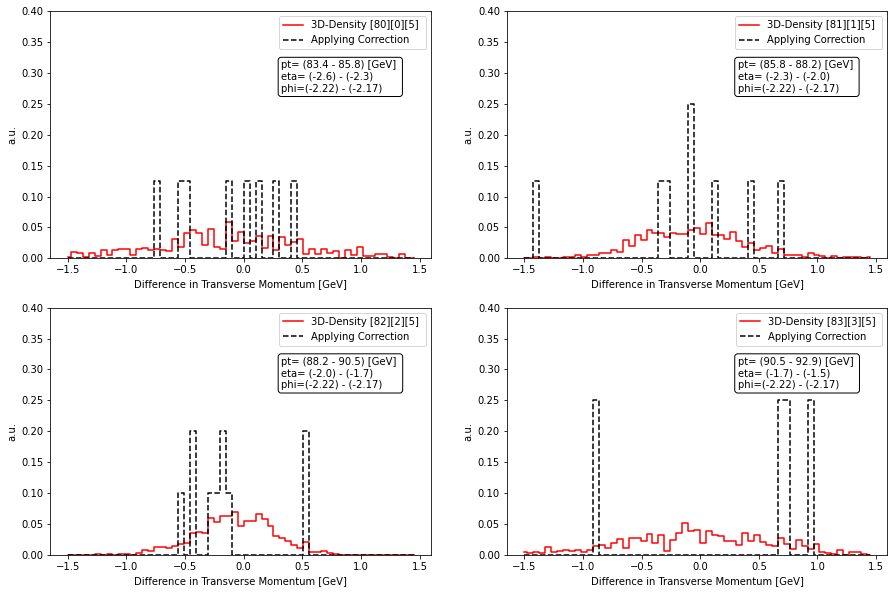

In [24]:
# looking at the edges of the pt bins
show_densities(80,0,5, third=False) 

## Accuracy

In [25]:
ptflat, counts = ak.flatten(events.muon_pt/1000), ak.num(events.muon_pt)
etaflat, counts = ak.flatten(events.muon_eta), ak.num(events.muon_eta)
phiflat, counts =ak.flatten(events.muon_phi), ak.num(events.muon_phi)
rand=np.random.rand(len(ptflat))

# bins=np.linspace(-0.6,0.6,30)
bins=overall_bins
bin_center=bins[:len(bins)-1]

smeared_pt=ptsmear.to_evaluator().evaluate(ptflat,etaflat,phiflat,rand)
smeared_pt_down=ptsmear_down.to_evaluator().evaluate(ptflat,etaflat,phiflat,rand)###

smeared_pt_unflatten=ak.unflatten(smeared_pt,counts)
smeared_pt_down_unflatten=ak.unflatten(smeared_pt_down,counts)###

weights_flattened=np.repeat(events.finalWeight,counts)

hist_correction,bins= np.histogram(smeared_pt, bins=bins, weights=weights_flattened)
hist_correction_down,bins= np.histogram(smeared_pt_down, bins=bins, weights=weights_flattened)###

pt_up_flat, count = ak.flatten(events.muon_pt_MUON_CB__1up/1000), ak.num(events.muon_pt_MUON_CB__1up)
pt_down_flat, count = ak.flatten(events.muon_pt_MUON_CB__1down/1000), ak.num(events.muon_pt_MUON_CB__1down) ####


bins_plot=np.linspace(1,110,100)
bins_plot=np.linspace(10,100,40)
bins_plot_center=bins_plot[:len(bins_plot)-1]

labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
colors=["tab:orange","tab:green"]

cb_dist,bins_plot= np.histogram(pt_up_flat, bins=bins_plot, weights=weights_flattened)
cb_dist_down,bins_plot= np.histogram(pt_down_flat, bins=bins_plot, weights=weights_flattened)####

correctionlib_dist, bins_plot=np.histogram(-smeared_pt+ptflat, bins=bins_plot, weights=weights_flattened)
correctionlib_dist_down, bins_plot=np.histogram(-smeared_pt_down+ptflat, bins=bins_plot, weights=weights_flattened)####
pt_dist, bins_plot=np.histogram(ptflat, bins=bins_plot, weights=weights_flattened)

fig, (ax1,ax2)=plt.subplots(2,1, figsize=(12,8), gridspec_kw={'height_ratios': [3, 2]},sharex=True)
ax1.step(bins_plot_center, cb_dist,label=labels[0],color=colors[0])
ax1.step(bins_plot_center, cb_dist_down,label=labels[1],color=colors[1])####
ax1.step(bins_plot_center,correctionlib_dist, label=r"Correction +1$\sigma$" ,color=colors[0] ,linestyle="dashed")
ax1.step(bins_plot_center,correctionlib_dist_down, label=r"Correction -1$\sigma$" ,color=colors[1] ,linestyle="dashed")
ax1.step(bins_plot_center, pt_dist, label="Nominal",color="tab:blue")


# ax2.step(bins_plot_center, correctionlib_dist/cb_dist ,label='(Correction)/({})'.format(labels[0]), color='black')
# ax2.step(bins_plot_center, pt_dist/cb_dist ,label='({})/(Calibration)'.format(labels[0]),color=colors[0] )
ax2.step(bins_plot_center, cb_dist/pt_dist ,label='{}'.format(labels[0]),color=colors[0] )
ax2.step(bins_plot_center, cb_dist_down/pt_dist ,label='{}'.format(labels[1]),color=colors[1] )
ax2.step(bins_plot_center,correctionlib_dist/pt_dist, label=r"Correction +1$\sigma$" ,color=colors[0] ,linestyle="dashed")
ax2.step(bins_plot_center,correctionlib_dist_down/pt_dist, label=r"Correction -1$\sigma$" ,color=colors[1] ,linestyle="dashed")



# ax1.set_yscale("log")
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel("Number of Events")
ampl.plot.draw_atlas_label(0.02, 0.98, ax=ax1,status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
# ax1.set_ylim(2e6,5e6)
ax1.legend()

ax2.set_ylim(0.994,1.006)
ax2.axhline(y = 1, color = 'black',alpha=0.5)
ax2.set_xlabel(r"Transverse Momentum [GeV]")
ax2.set_ylabel("Systematic / Nominal")
ax2.legend(loc="lower right")

plt.show()

## Invariant Mass

In [112]:
bins_middle=np.linspace(80,100,50)
# bins_middle=np.linspace(85,95,100)
bins_variable=bins_middle
bins_variable_center=bins_variable[:len(bins_variable)-1]

selected_pt=selection(events, "muon_pt")
selected_cb=selection(events, "muon_pt_MUON_CB__1up")
selected_cb_down=selection(events, "muon_pt_MUON_CB__1up")####

m_cb=getInvariantMass(selected_cb, "muon_pt_MUON_CB__1up")
m_cb_down=getInvariantMass(selected_cb, "muon_pt_MUON_CB__1down")#####

hist_cb, bins_variable=np.histogram(m_cb, bins=bins_variable,weights=selected_cb.finalWeight)
hist_cb_down, bins_variable=np.histogram(m_cb_down, bins=bins_variable,weights=selected_cb_down.finalWeight)####

m_pt=getInvariantMass(selected_pt,"muon_pt")
hist_pt, bins_variable=np.histogram(m_pt, bins=bins_variable,weights=selected_pt.finalWeight)

rand=np.random.rand(len(selected_pt))
momentum=selected_pt.muon_pt
eta=selected_pt.muon_eta
phi=selected_pt.muon_phi

def getInvariantMass_smear(events,partofevents,correction):
    momentum=events[partofevents]/1000
    eta=events.muon_eta
    phi=events.muon_phi
    rand=np.random.rand(len(momentum))
    first=correction.to_evaluator().evaluate(momentum[:,0],eta[:,0],phi[:,0],rand)#
    # print(first[0:100].tolist())
    first_smeared=(momentum[:,0]-first)
    second=correction.to_evaluator().evaluate(momentum[:,1],eta[:,1],phi[:,1],rand)
    second_smeared=(momentum[:,1]-second)


    m = np.sqrt(2*first_smeared*second_smeared*
        (np.cosh(eta[:,0]-eta[:,1]) - np.cos(phi[:,0]-phi[:,1])))
    return(m)


m_correction=getInvariantMass_smear(selected_pt, "muon_pt", ptsmear)
m_correction_down=getInvariantMass_smear(selected_pt, "muon_pt", ptsmear_down)####

hist_correction, bins_variable=np.histogram(m_correction, bins=bins_variable,weights=selected_pt.finalWeight)
hist_correction_down, bins_variable=np.histogram(m_correction_down, bins=bins_variable,weights=selected_pt.finalWeight) ####

fig, (ax1,ax2)=plt.subplots(2,1, figsize=(12,8), gridspec_kw={'height_ratios': [4, 2]},sharex=True)

labels=[r"Resolution $+1\sigma$",r"Resolution $-1\sigma$"]
colors=["tab:orange","tab:green"]

ax1.step(bins_variable_center, hist_cb, label=labels[0],color=colors[0])
ax1.step(bins_variable_center, hist_cb_down, label=labels[1],color=colors[1])
ax1.step(bins_variable_center, hist_correction, label=r"Correction +1$\sigma$",color=colors[0], linestyle="dashed")
ax1.step(bins_variable_center, hist_correction_down, label=r"Correction -1$\sigma$",color=colors[1], linestyle="dashed")####
ax1.step(bins_variable_center, hist_pt, label="Nominal",color="tab:blue")

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel("Number of Events")
ampl.plot.draw_atlas_label(0.02, 0.98, ax=ax1,status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
# ax1.set_ylim(2e6,5e6)
ax1.legend()

#########################################################
# ax2.step(bins_variable_center,hist_correction/hist_cb,label="(Correction)/({})".format(labels[0]),color="black")
# ax2.step(bins_variable_center,hist_correction/hist_pt,label="(Correction)/(Calibration)",color="tab:blue")

ax2.step(bins_variable_center,hist_cb/hist_pt,label="{}".format(labels[0]),color=colors[0])
ax2.step(bins_variable_center,hist_cb_down/hist_pt,label="{}".format(labels[1]),color=colors[1])####
ax2.step(bins_variable_center,hist_correction/hist_pt,label=r"Correction +1$\sigma$",color=colors[0], linestyle="dashed")
ax2.step(bins_variable_center,hist_correction_down/hist_pt,label=r"Correction -1$\sigma$",color=colors[1], linestyle="dashed")####

ax2.set_ylim(0.95,1.05)
ax2.axhline(y = 1, color = 'black')
ax2.set_xlabel(r"$m(\mu_{1},\mu_{2})$ [GeV]")
ax2.set_ylabel(" Systmatic / Nominal")
ax2.legend(loc="lower left")

plt.show()

## Fit of Z-Mass

In [113]:
from scipy.stats import crystalball

def Gaussian(x,M,sigma_gs):
    return 0.1*np.exp(-(x-M)**2/(2*sigma_gs))

def combined_CB_Gaussian(x,M,sigma_cb,sigma_gs,a,b,n):
    # f=0.9
    return b*CB(x,M,sigma_cb,n)+a*Gaussian(x,M,sigma_gs)

def CB(x,M,sigma_cb,n):
    alpha=1.1
    # n=1.5
    return crystalball.pdf(x,alpha,n,M,sigma_cb)

def fit_procedure(bins, hist_data,sigma=None):

    bounds=((80,1,1,0.1,0.1,1),(100,5,5,1e9,1e9,10))
    popt, pcov=curve_fit(combined_CB_Gaussian, bins, hist_data, p0=[90,2,2,1,1,1.5],bounds=bounds)
    return popt, pcov

def fit_procedure_sigma(bins, hist_data,sigma):

    bounds=((80,1,1,0.1,0.1,1),(100,10,10,1e9,1e9,5))
    popt, pcov=curve_fit(combined_CB_Gaussian, bins, hist_data, p0=[90,2,2,1,1,1.5],bounds=bounds,sigma=sigma, absolute_sigma=True,maxfev=10000)
    return popt, pcov

In [114]:
# hist_nominal_norm, bins_variable=np.histogram(m_pt, bins=bins_variable,weights=selected_pt.finalWeight,density=True)
hist_nominal_norm, bins_variable=np.histogram(m_pt, bins=bins_variable,weights=selected_pt.finalWeight)
error_nominal_squared, bins_variable=np.histogram(m_pt, bins=bins_variable,weights=(selected_pt.finalWeight)**2)
error_nominal=np.sqrt(error_nominal_squared)

# hist_cb_up_norm, bins_variable=np.histogram(m_cb, bins=bins_variable,weights=selected_cb.finalWeight,density=True)
hist_cb_up_norm, bins_variable=np.histogram(m_cb, bins=bins_variable,weights=selected_cb.finalWeight)
error_cb_up_squared, bins_variable=np.histogram(m_cb, bins=bins_variable,weights=(selected_cb.finalWeight)**2)
error_cb_up=np.sqrt(error_cb_up_squared)

# hist_cb_down_norm, bins_variable=np.histogram(m_cb_down, bins=bins_variable,weights=selected_cb_down.finalWeight,density=True)
hist_cb_down_norm, bins_variable=np.histogram(m_cb_down, bins=bins_variable,weights=selected_cb_down.finalWeight)
error_cb_down_squared, bins_variable=np.histogram(m_cb_down, bins=bins_variable,weights=(selected_cb_down.finalWeight)**2)
error_cb_down=np.sqrt(error_cb_down_squared)

# hist_cor_up_norm, bins_variable=np.histogram(m_correction, bins=bins_variable,weights=selected_pt.finalWeight,density=True)
hist_cor_up_norm, bins_variable=np.histogram(m_correction, bins=bins_variable,weights=selected_pt.finalWeight)
error_cor_up_squared, bins_variable=np.histogram(m_correction, bins=bins_variable,weights=(selected_pt.finalWeight)**2)
error_cor_up=np.sqrt(error_cor_up_squared)

# hist_cor_down_norm, bins_variable=np.histogram(m_correction_down, bins=bins_variable,weights=selected_pt.finalWeight,density=True)
hist_cor_down_norm, bins_variable=np.histogram(m_correction_down, bins=bins_variable,weights=selected_pt.finalWeight)
error_cor_down_squared, bins_variable=np.histogram(m_correction_down, bins=bins_variable,weights=(selected_pt.finalWeight)**2)
error_cor_down=np.sqrt(error_cor_down_squared)

hist_data=[hist_nominal_norm,hist_cb_up_norm,hist_cb_down_norm,hist_cor_up_norm,hist_cor_down_norm]
hist_error=[error_nominal,error_cb_up,error_cb_down,error_cor_up,error_cor_down]
hist_names=["Nominal",labels[0],labels[1],r"Correction +1$\sigma$",r"Correction -1$\sigma$"]


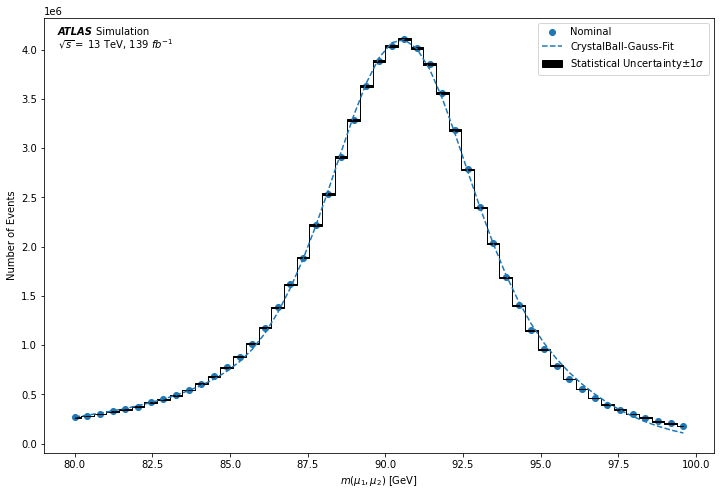

In [115]:

fig, ax=plt.subplots(figsize=(12,8))

# ax.step(bins_variable_center, hist_nominal_norm, label="Nominal",color="tab:blue",where="mid")
ax.scatter(bins_variable_center, hist_nominal_norm, label="Nominal",color="tab:blue")
# popt, pcov= fit_procedure_sigma(bins_variable_center,hist_nominal_norm,sigma=error_nominal)
popt, pcov= fit_procedure(bins_variable_center,hist_nominal_norm)
ax.plot(bins_variable_center,combined_CB_Gaussian(bins_variable_center, *popt),label="CrystalBall-Gauss-Fit", linestyle="dashed")
up=hist_nominal_norm+error_nominal
down=hist_nominal_norm-error_nominal
ax.fill_between(bins_variable_center,up,down, where=(up >= down),alpha=1, color="black", label=r"Statistical Uncertainty$\pm1\sigma$",step="mid")

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_ylabel("Number of Events")
# ax.text(82.5,3e6,"Fit without Error, \nMass=(90.500+-0.013) GeV")
ampl.plot.draw_atlas_label(0.02, 0.98, ax=ax,status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
ax.set_xlabel(r"$m(\mu_{1},\mu_{2})$ [GeV]")
# ax1.set_ylim(2e6,5e6)
ax.legend()

plt.show()


In [122]:
def plotCB(*numbers,sigma=False):
    fig, ax=plt.subplots(figsize=(12,8))
    colors=["tab:blue","tab:orange","tab:green","tab:red","tab:blue"]

    for element in numbers:
        element=int(element)
        ax.step(bins_variable_center, hist_data[element], label=hist_names[element],color=colors[element],where="mid")
        up=hist_data[element]+hist_error[element]
        down=hist_data[element]-hist_error[element]

        ax.fill_between(bins_variable_center,up,down, where=(up >= down),alpha=1, color="black", label=r"Statistical Uncertainty$\pm1\sigma$",step="mid") 
        if sigma==True:
            popt, pcov= fit_procedure_sigma(bins_variable_center,hist_data[element],sigma=hist_error[element])
            # print("m with sigma: ", popt[0],"+-",np.sqrt(np.diag(pcov))[0])
            ax.plot(bins_variable_center,combined_CB_Gaussian(bins_variable_center, *popt),color=colors[element],label="CrystalBall-Gauss-Fit", linestyle="dashed")
            print("Z-Mass{}:".format(hist_names[element]), round(popt[0],3))
        else:
            popt, pcov= fit_procedure(bins_variable_center,hist_data[element])
            ax.plot(bins_variable_center,combined_CB_Gaussian(bins_variable_center, *popt),color=colors[element],label="CrystalBall-Gauss-Fit", linestyle="dashed")
            print("Z-Mass{}:".format(hist_names[element]), round(popt[0],3))


    # # ax.step(bins_variable_center, hist_nominal_norm, label="Nominal",color="tab:blue",where="mid")
    # ax.plot(bins_variable_center, hist, label=hist_names[element],color="tab:red")
    # if sigma==True:
    #     popt, pcov= fit_procedure_sigma(bins_variable_center,hist,sigma=errors)
    # else:
    #     popt, pcov= fit_procedure(bins_variable_center,hist)
    # print("values",popt)
    # print("errors",np.sqrt(np.diag(pcov)))
    # # popt, pcov= fit_procedure(bins_variable_center,hist_nominal_norm)
    # ax.plot(bins_variable_center,combined_CB_Gaussian(bins_variable_center, *popt),color="tab:red",label="CrystalBall-Gauss-Fit", linestyle="dashed")
    # up=hist+errors
    # down=hist-errors
    # ax.fill_between(bins_variable_center,up,down, where=(up >= down),alpha=1, color="black", label=r"Statistical Uncertainty$\pm1\sigma$",step="mid")

    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # ax.text(82.5,3e6,"Fit including Error, \nMass=(90.462+-0.020) GeV")
    ax.set_ylabel("Number of Events")
    ampl.plot.draw_atlas_label(0.02, 0.98, ax=ax,status="", simulation=True, energy="13 TeV", lumi="139 $fb^{-1}$")
    ax.set_xlabel(r"$m(\mu_{1},\mu_{2})$ [GeV]")
    # ax.set_xlim(89,92)
    # ax.set_ylim(0.8e6,1.0e6)
    ax.legend()

plt.show()
# bounds=((80,1,1,0.1,0.1,1),(100,5,5,1e9,1e9,5))
c=3
plotCB("0",sigma=False)


Z-MassNominal: 90.51


In [118]:
for count,element in enumerate(hist_data):
    popt, pcov= fit_procedure(bins_variable_center,element)
    print(hist_names[count])
    print(popt[0], "+-",np.sqrt(np.diag(pcov))[0])
    print()

Nominal
90.50984256234328 +- 0.01215211839271621

Resolution $+1\sigma$
90.49986141273942 +- 0.011448808792198537

Resolution $-1\sigma$
90.51953861613526 +- 0.01271815047621289

Correction +1$\sigma$
90.51658406356553 +- 0.011817394586515161

Correction -1$\sigma$
90.50745105950212 +- 0.011870402847171852

